# Eyettention

**Configuration**

In [1]:
import numpy as np
#configuration
#Chinese
cf = {"model_pretrained": "bert-base-chinese",
      "atten_type": 'local-g',
      #batch computation for training (BSC dataset)
      "max_sn_len": 27,
      "max_sp_len": 40
     }

In [2]:
!pip install --upgrade transformers==4.27.0

In [3]:
# You can also just download the file model.py, which is only used in this tutorial
!git clone https://github.com/aeye-lab/Eyettention

fatal: destination path 'Eyettention' already exists and is not an empty directory.


**Load the model and download pre-trained weights**

In [4]:
from Eyettention import model
import torch
from torch.utils import model_zoo

#DEVICE = 'cuda'
DEVICE = 'cpu'

pretrained=True

#load model
dnn = model.Eyettention(cf)
dnn.eval()
if pretrained:  
    #for Chinese
    dnn.load_state_dict(model_zoo.load_url('https://github.com/aeye-lab/Eyettention/releases/download/v1.1/Eyettention_chinese.pth', map_location=torch.device('cpu')))

keeping Bert with pre-trained weights


Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


**Tokenization**
<br>
**Introduction**: https://huggingface.co/learn/nlp-course/chapter2/4?fw=pt

In [5]:
from transformers import BertTokenizerFast
#initialize tokenizer
tokenizer = BertTokenizerFast.from_pretrained(cf['model_pretrained'])

In [6]:
sentence = '中国选手在男子滑雪比赛中有望蝉联冠军'
#add special tokens
#text = ('[CLS]' + ' ' + sentence + ' ' + '[SEP]').split()
#print(text)
tokens = tokenizer(sentence, add_special_tokens=True, max_length=cf['max_sn_len'], padding='max_length')

In [7]:
print(tokenizer.tokenize(sentence, add_special_tokens=True))

['[CLS]', '中', '国', '选', '手', '在', '男', '子', '滑', '雪', '比', '赛', '中', '有', '望', '蝉', '联', '冠', '军', '[SEP]']


In [8]:
print(tokens)

{'input_ids': [101, 704, 1744, 6848, 2797, 1762, 4511, 2094, 3998, 7434, 3683, 6612, 704, 3300, 3307, 6068, 5468, 1094, 1092, 102, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]}


In [9]:
#we do not need word index in Chinese language since each character is encoded independently. 

**Prepare features**

In [10]:
def compute_BSC_word_length(sentence, lac):
    word_string = lac.run(sentence)
    #print(word_string)
    word_len = [len(i) for i in word_string]
    wl_list = []
    for wl in word_len:
        wl_list.extend([wl]*wl)
    arr = np.asarray(wl_list, dtype=np.float32)
    #length of a punctuation is 0, plus an epsilon to avoid division output inf
    arr[arr==0] = 1/(0+0.5)
    arr[arr!=0] = 1/(arr[arr!=0])
    return arr

def pad_seq(seqs, max_len, dtype=np.int32, fill_value=np.nan):
    padded = np.full((len(seqs), max_len), fill_value=fill_value, dtype=dtype)
    for i, seq in enumerate(seqs):
        padded[i, 1:(len(seq)+1)] = seq
    return padded

In [11]:
#segment sentene into word (not character) to calculate word length features
!pip install LAC

In [12]:
!pip install paddlepaddle==2.5.2
from LAC import LAC
lac = LAC(mode="seg")

In [13]:
#compute the word length feature
text_word_len = [compute_BSC_word_length(txt, lac) for txt in [sentence]]
text_word_len = pad_seq(text_word_len, cf['max_sn_len'], fill_value=np.nan, dtype=np.float32)
print(text_word_len)

[[nan 0.5 0.5 0.5 0.5 1.  0.5 0.5 0.5 0.5 0.5 0.5 1.  0.5 0.5 0.5 0.5 0.5
  0.5 nan nan nan nan nan nan nan nan]]


In [14]:
#Download precomputed sn_word_len mean and std (from CELER dataset) for feature normalization
import pickle
!wget https://github.com/aeye-lab/Eyettention/releases/download/v1.1/feature_norm_BSC.pickle
path = 'feature_norm_BSC.pickle'
file_to_read = open(path, "rb")
loaded_dictionary = pickle.load(file_to_read)
sn_word_len_mean = loaded_dictionary['sn_word_len_mean'].numpy()
sn_word_len_std = loaded_dictionary['sn_word_len_std'].numpy()

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [15]:
#normalize word length feature
text_word_len = (text_word_len - sn_word_len_mean)/sn_word_len_std
text_word_len = np.nan_to_num(text_word_len)

In [16]:
tokens['input_ids'] = torch.tensor([tokens['input_ids']]).to(DEVICE)
tokens['attention_mask'] = torch.tensor([tokens['attention_mask']]).to(DEVICE)
word_len = torch.tensor([text_word_len.squeeze()]).to(DEVICE)

**Generate synthetic scanpath**

In [17]:
from sklearn.preprocessing import LabelEncoder
#prepare the saccade range classes for model predictions, cf["max_sn_len"]-1 -> stop class
le = LabelEncoder()
le.fit(np.append(np.arange(-cf["max_sn_len"]+3, cf["max_sn_len"]-1), cf["max_sn_len"]-1))
#le.classes_

LabelEncoder()

In [27]:
syn_scanpath, density_pred = dnn.scanpath_generation(sn_emd=tokens['input_ids'],
                                                     sn_mask=tokens['attention_mask'],
                                                     word_ids_sn=None,
                                                     sn_word_len = word_len,
                                                     le=le,
                                                     max_pred_len=50)

In [19]:
def post_process_scanpath(syn_scanpath, sn_len):
    syn_scanpath = syn_scanpath.detach().to('cpu').numpy()
    max_sp_len = syn_scanpath.shape[1]

    #Find the number "sn_len+1" -> the stop class
    stop_indx = []
    for i in range(syn_scanpath.shape[0]):
        stop = np.where(syn_scanpath[i,:]==(sn_len[i]+1))[0]
        if len(stop)==0:#no stop class can be find -> exceeds the maximum length of the generated scanpath
            stop_indx.append(max_sp_len-1)
        else:
            stop_indx.append(stop[0])

    #Truncating data after the stop class
    syn_scanpath_cut = [syn_scanpath[i][1:stop_indx[i]] for i in range(syn_scanpath.shape[0])]
    return syn_scanpath_cut

In [20]:
sn_len = (torch.sum(tokens['attention_mask'], axis=1) - 2).detach().to('cpu').numpy()

In [28]:
syn_scanpath = post_process_scanpath(syn_scanpath, sn_len)
print(syn_scanpath[0])

[ 1  2  4  6  9 12 16]


In [29]:
fixated_character = [sentence[idx-1] for idx in syn_scanpath[0]] #python index start from 0, our model prediction index start from 1
print(fixated_character)

['中', '国', '手', '男', '雪', '中', '联']


**Prediction visualization**

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["font.sans-serif"]=['SimHei']
def visualize_distribution(syn_scanpath, density_pred, timestep, text):
    #visualize density map
    plt.figure(figsize = (25,5))
    sac_range = np.append(np.arange(-cf["max_sn_len"]+3, cf["max_sn_len"]-1), cf["max_sn_len"]-1)

    #current gaze position
    cur_loc = syn_scanpath[timestep]
    #convert the saccade range classes to the target word indexes
    target_loc = sac_range + cur_loc

    prob_valid = density_pred[np.where((0 <= target_loc) & (target_loc <= (len(text)-2)))]#exclude SEP token
    prob_valid = np.append(prob_valid, density_pred[-1])

    plt.subplot(2, 1, 2)
    sns.heatmap(prob_valid[np.newaxis, :], annot=np.array(text)[np.newaxis,:], fmt="", linewidths=2, cmap="YlGnBu", xticklabels=False, yticklabels=False, cbar=True, annot_kws={"fontsize":15}, cbar_kws = dict(use_gridspec=False,location="top"))
    y = 3
    for past_ts in range(timestep):
        dy = 0
        dx = syn_scanpath[past_ts+1] - syn_scanpath[past_ts]
        #if refixation, display on next line
        if dx <= 0:
            dy = -0.5
            plt.arrow(syn_scanpath[past_ts]+0.5, y, dx, dy, color='b', ec ='blue', head_width=0.2)
            y = y + dy
        else:
            plt.arrow(syn_scanpath[past_ts]+0.5, y, dx, dy, color='b', ec ='blue', head_width=0.2)

    plt.arrow(syn_scanpath[timestep]+0.5, y, (syn_scanpath[timestep+1]-syn_scanpath[timestep]), 0, color='r', ec ='red', head_width=0.2)
    plt.xlim([0, len(text)])
    plt.ylim([0, 3.5])
    ax = plt.gca()
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

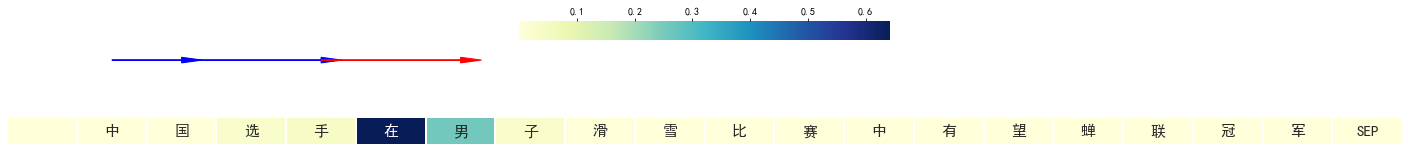

In [32]:
sn_char = [c for c in sentence]
sn_char = [''] + sn_char + ['SEP']
sample_index=0
timestep = 2
visualize_distribution(syn_scanpath=syn_scanpath[sample_index],
                       density_pred=density_pred[timestep][sample_index].detach().numpy(),
                       timestep=timestep,
                       text=sn_char)

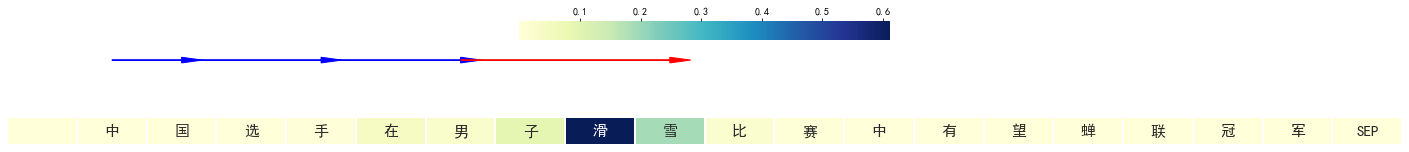

In [33]:
sample_index=0
timestep = 3
visualize_distribution(syn_scanpath=syn_scanpath[sample_index],
                       density_pred=density_pred[timestep][sample_index].detach().numpy(),
                       timestep=timestep,
                       text=sn_char)